<b>Rubric</b>

|평가항목|상세기준|
|--------|--------|
|1. 변역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌따.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attention Seq2seq모델이 정상적으로 구동된다.|seq2seq모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상저긍로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import time
import re
import os
import io

### Step1. 데이터 다운로드

In [2]:
from requests import get
import os

os.mkdir('./data')

def download(url, file_name):
    with open(file_name, "wb") as file:   
        response = get(url)
        file.write(response.content)
        
url = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1'
file_name = 'korean-english-park.train.tar.gz'

download(f'{url}/{file_name}', f'./data/{file_name}')

In [3]:
os.listdir('./data')

['korean-english-park.train.tar.gz']

In [4]:
import tarfile

with tarfile.open(f'./data/{file_name}') as tar:
    tar.extractall("./data")

In [6]:
os.listdir('./data')

['korean-english-park.train.ko',
 'korean-english-park.train.en',
 'korean-english-park.train.tar.gz']

### Step2. 데이터 정제
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [7]:
def load_file(file_name):
    with open(f'./data/{file_name}', "r") as f:
        result = f.read().splitlines()

    return result

In [9]:
kor_raw = load_file('korean-english-park.train.ko')
en_raw = load_file('korean-english-park.train.en')

print("Data Size \n kor_raw:", len(kor_raw), 
      "\n en_raw:", len(en_raw))
print("Example:")
for sen in kor_raw[0:100][::20]: print(">>", sen)

Data Size 
 kor_raw: 94123 
 en_raw: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [10]:
dataset = zip(kor_raw, en_raw)
cleaned_corpus = set(dataset)

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

In [11]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

In [12]:
kor_corpus = []
eng_corpus = []


for kor, eng in cleaned_corpus:
    _kor = preprocess_sentence(kor)
    
    if len(_kor) <=40 and len(_kor) >= 5:
        kor_corpus.append(_kor)
        
        _eng = preprocess_sentence(eng, s_token=True, e_token=True)
        eng_corpus.append(_eng)

In [13]:
print("Korean:", kor_corpus[100])
print("English:", eng_corpus[100])

Korean: 그러나 4년 전 , 영화 반지의 제왕 왕의 귀환 원제
English: <start> but the globes have not correctly forecast an oscar best picture winner in four years , the last one being the lord of the rings <end>


In [14]:
print("Korean:", kor_corpus[50])
print("English:", eng_corpus[50])

Korean: 저녁식사 부분은 순조롭지 못하다
English: <start> the dinner part can be tough <end>


In [15]:
print("Korean:", kor_corpus[38])
print("English:", eng_corpus[38])

Korean: 군사용 기구에서 생명을 구하는 시술 기구로
English: <start> i hope it can help patients around the world , he said . <end>


In [16]:
print("Korean:", kor_corpus[3505])
print("English:", eng_corpus[3505])

Korean: 하지만 멀티미디어용 컴퓨터 한 대에는 약 35명의 학생들이 있다 .
English: <start> however , there are about 35 students for every multimedia computer . <end>


### Step3. 데이터 토큰화
tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [17]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [18]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

print(f'Korean Vocab Size: {len(kor_tokenizer.index_word)}')
print(f'English Vocab Size: {len(eng_tokenizer.index_word)}')

Korean Vocab Size: 39496
English Vocab Size: 16689


In [19]:
from sklearn.model_selection import train_test_split

kor_train, kor_test, eng_train, eng_test = train_test_split(kor_tensor, eng_tensor, test_size=0.2)

len(kor_train), len(kor_test), len(eng_train), len(eng_test)

(11982, 2996, 11982, 2996)

******* 변수명 헷갈리지 말기! *******

kor_train, kor_test, eng_train, eng_test

### Step 4. 모델 설계
Attention 기반 Seq2seq 모델을 설계! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아진다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        out = self.dropout(out)
        
        return out

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
        self.dropout = tf.keras.layers.Dropout(rate=0.2)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = self.dropout(out)
        
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [23]:
# 코드를 실행하세요.
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 16690)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


### Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [25]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [26]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 188/188 [01:52<00:00,  1.68it/s, Loss 0.6272]


In [29]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx:idx+BATCH_SIZE],
                                eng_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, eng_test.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(kor_test[idx:idx+BATCH_SIZE],
                                    eng_test[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    eng_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 47/47 [00:10<00:00,  4.51it/s, Test Loss 1.9130]


In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

Input: 무슨 영화를 좋아하세요 ? 부귀영화요
Predicted translation: it s not doing . <end> 


/tmp/ipykernel_184/1497602573.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_184/1497602573.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


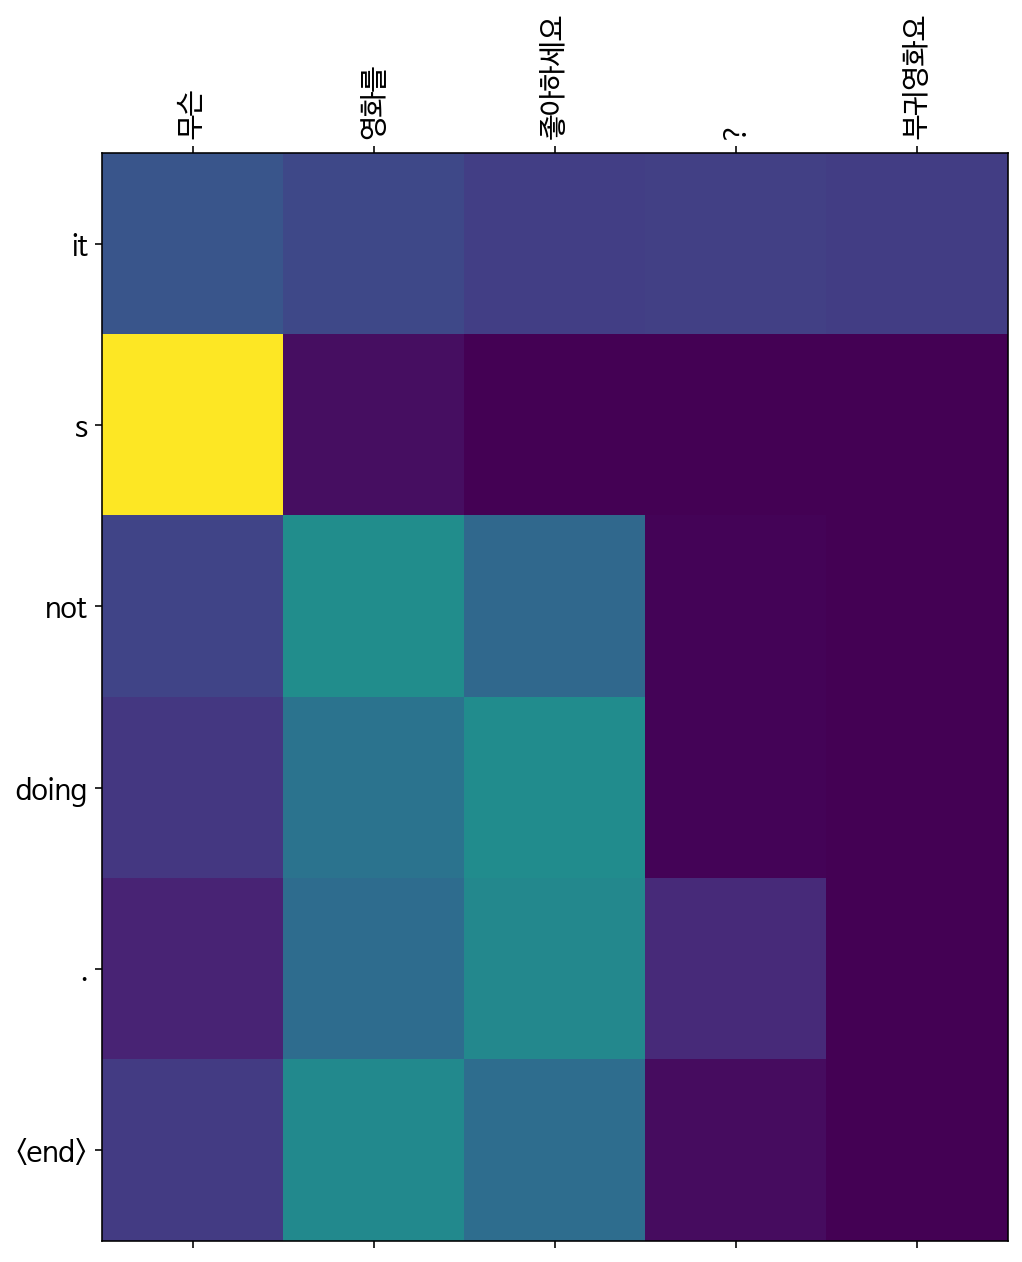

In [43]:
translate("무슨 영화를 좋아하세요? 부귀영화요", encoder, decoder)

Input: 말하기 전에 생각했나요 ?
Predicted translation: but <end> 


/tmp/ipykernel_184/1497602573.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_184/1497602573.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


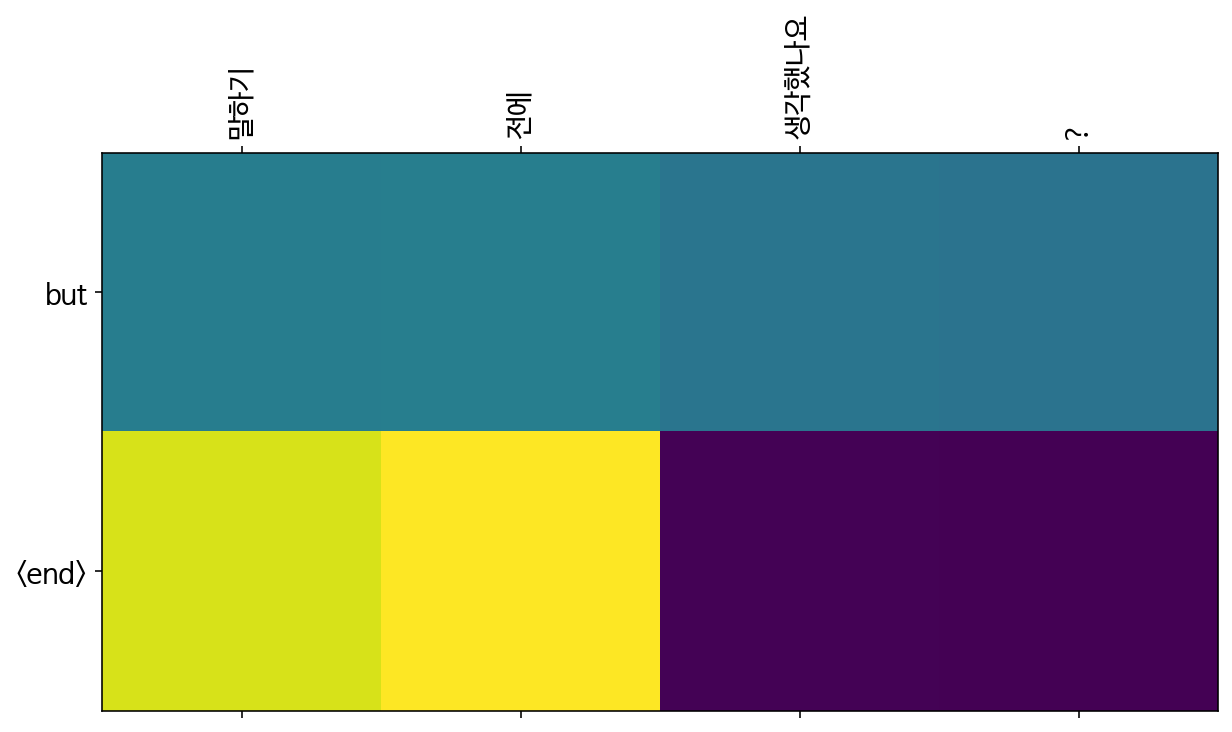

In [44]:
translate("말하기 전에 생각했나요?", encoder, decoder)

Input: 입에서 똥나온다
Predicted translation: patients around <end> 


/tmp/ipykernel_184/1497602573.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_184/1497602573.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


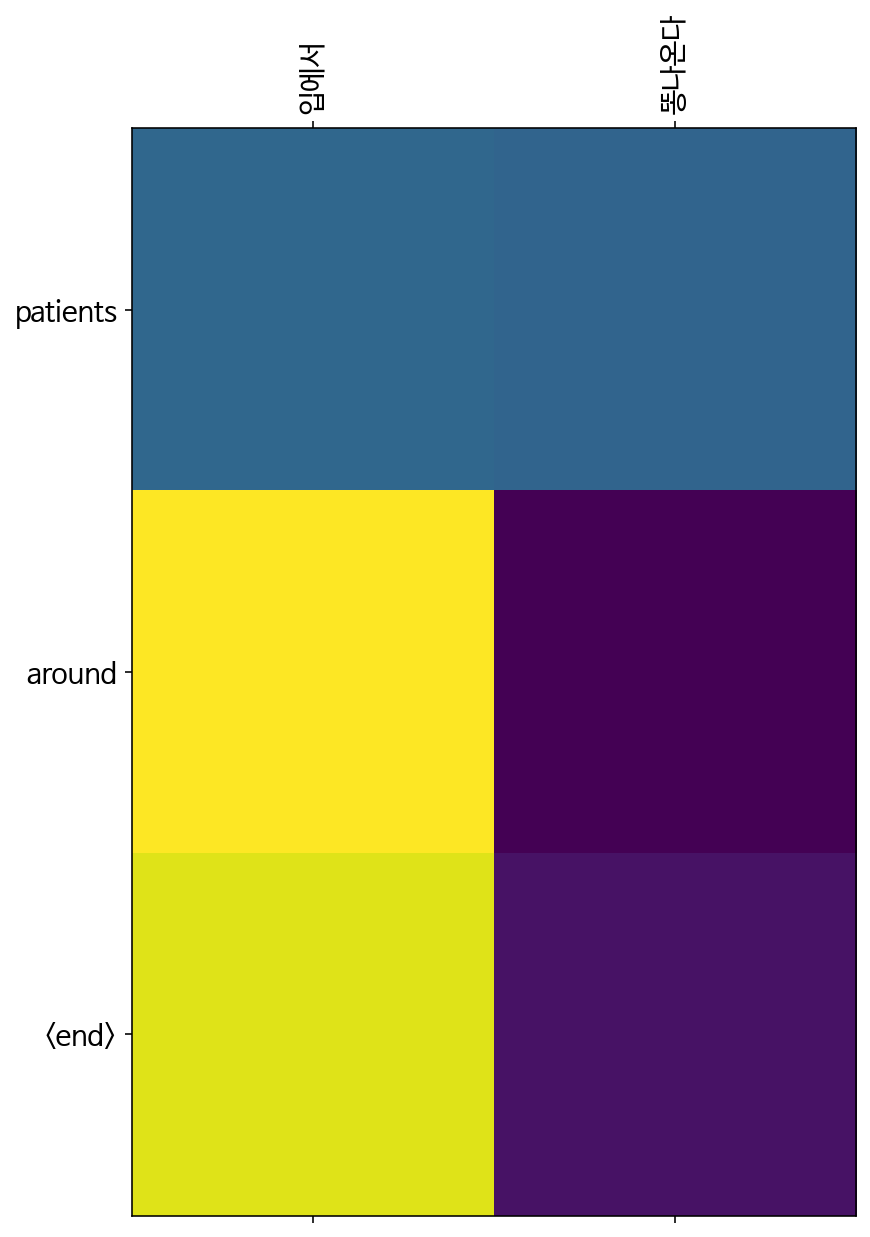

In [45]:
translate("입에서 똥나온다", encoder, decoder)

Input: 오펜하이머
Predicted translation: patients around <end> 


/tmp/ipykernel_184/1497602573.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_184/1497602573.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


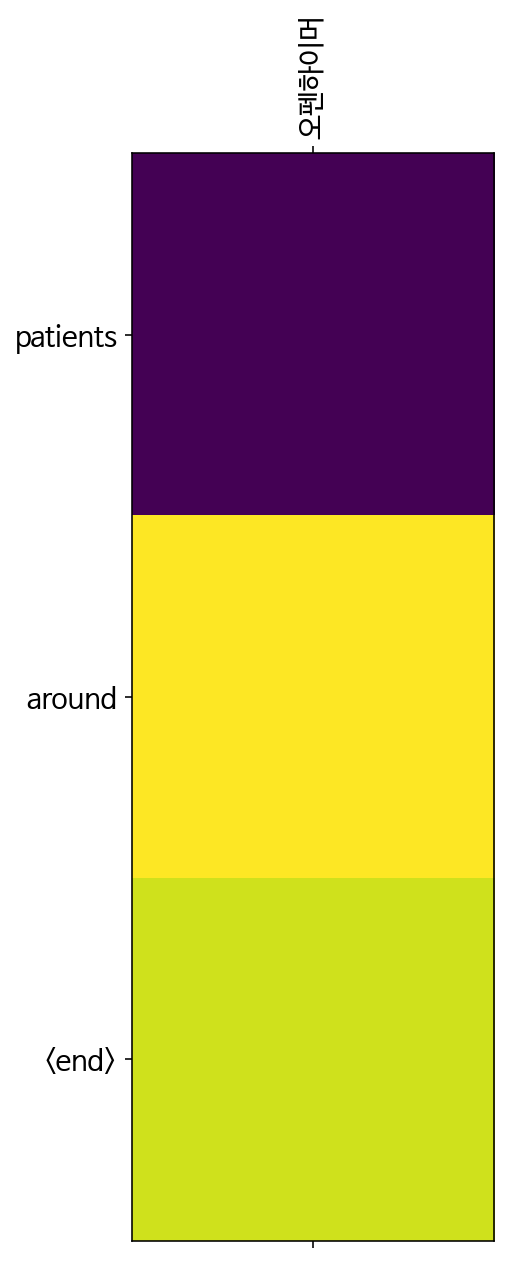

In [46]:
translate("오펜하이머", encoder, decoder)

Input: 오늘 점심메뉴 추천해줘
Predicted translation: pope benedict says she s economic news poll today show in the economy and helicopters attacked today . <end> 


/tmp/ipykernel_184/1497602573.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_184/1497602573.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


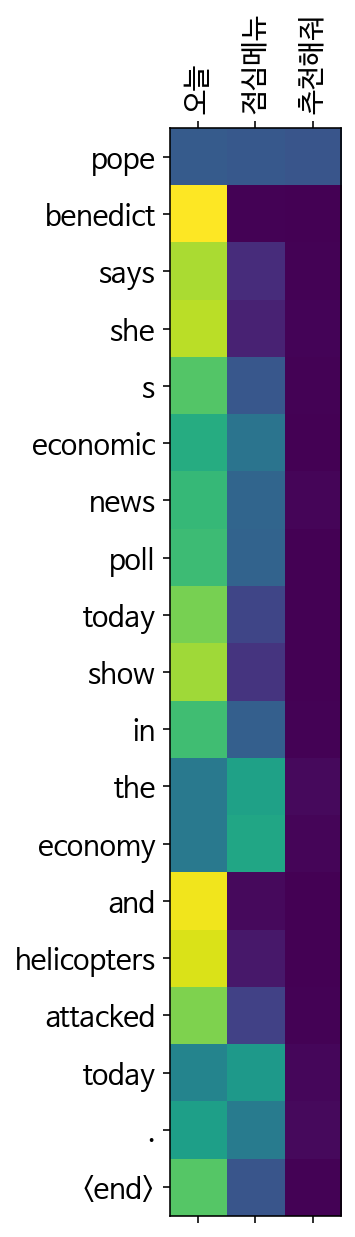

In [47]:
translate("오늘 점심메뉴 추천해줘", encoder, decoder)

#### 회고

1. <b>데이터가 조금 이상하다.</b> <br>
- 다른 문장구조로 인한 정확하지 않은 매칭: <br> 
  이상하다의 의미는, 한국말과 정확히 매칭되지 않는다. 좀 더 구체적으로는, 문장과 단어란 구어체 또는 문체에서 앞뒤 맥락과 내용과 직결되다 보니 문장 또는 단어 단위로 뜯어서 본다고 할 떄, 영어와 한국어의 문장구조 자체가 틀리다 보니 정확히 매칭되지 않는다. <br><br>
  
  
2. <b>컴퓨터의 한계..?</b> <br>
- 컴퓨터란 인풋값을 넣으면 블랙박스에 의해서 아웃값이 나오는 단순한 기계인지라, 컴퓨터한테 문맥에 맞는 번역을 해달라고 하는게 무리일 수도 있다. 어쩌면 이게 아직 한계일 수도 있다. 그런의미에서 chatGPT의 알고리즘 어떨지 진짜 궁금하긴 하다....